# Interpretabilidad de Modelos de Machine Learning

Los modelos de machine learning normalmente son contemplados como "cajas negras" en donde no se sabe con certeza la importancia y el peso de cada variable en el resultado del modelo tanto para observaciones individuales, como para dar una explicación general del modelo.

Este notebook está diseñado para dar una aproximación a la librería *shap*, la cual provee múltiples *Explainers* para diferentes tipos de modelos de machine learning y con la que se puede hacer diferentes tipos de gráficas que explican dichos modelos.

Se explorará la librería usando dos modelos que se adaptan a dos datasets diferentes para mostrar la importancia de ajustar las escalas para que la interpretabilidad sea desarrollada correctamente.

Este notebook usa *Keras - TensorFlow* para lo cual, asegúrese que ha seleccionado **GPU T4** como **tipo de entorno de ejecución** en la configuración de la sesión de Google Colab.

**Este notebook está diseñado con funcionalidades de autocalificación. Para el correcto funcionamiento, solo escriba su código  dentro de los espacios marcados para ello.**

## Contenidos

- [0 - Configuración de Google Colab](#0)
- [1 - Paquetes](#1)
- [2 - Funciones Auxiliares](#2)
- [3 - Modelo de clasificación](#3)
    - [3.1 - Exploración Inicial del Dataset y Pre-Procesamiento](#3-1)
    - [3.2 - Construcción y Entrenamiento del Modelo](#3-2)
    - [3.3 - SHAP y Explainers](#3-3)
    - [3.4 - Gráficas Locales](#3-4)
    - [3.5 - Gráficas Globales](#3-5)
- [4 - Modelo de Regresión](#4)
    - [4.1 - Exploración Inicial del Dataset y Pre-Procesamiento](#4-1)
    - [4.2 - Construcción y Entrenamiento del Modelo](#4-2)
    - [4.3 - SHAP y Explainers](#4-3)
    - [4.4 - Gráficas Locales](#4-4)
    - [4.5 - Gráficas Globales](#4-5)
- [5 - Hazlo Tu Mismo (Ungraded)](#5)
- [6 - Bibliografía](#6)



<a name='0'></a>
## 0 - Configuración de Google Colab

Asegúrese que la carpeta que se incluye con este notebook sea guardada dentro de **Mi Unidad** en su cuenta de Google Drive. Ejecute la siguiente celda y acceda a su cuenta, dando los permisos necesarios. Esto hará que este notebook tenga acceso a los archivos necesarios para la autocalificación.

In [1]:
%cd "/media/juan/Nuevo vol/preprocess_sem_5/lstm_Feb_16/"

/media/juan/Nuevo vol/preprocess_sem_5/lstm_Feb_16


In [2]:
#conda info --


from platform import python_version

print(python_version())



3.11.5


In [5]:
pip install tensorflow[and-cuda]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 39.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 41.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 41.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 43.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.2/581.2 MB 14.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 42.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 MB 36.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.6/89.6 MB 24.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 39.

<a name='1'></a>
## 1 - Paquetes Necesarios

La siguiente celda importa todas las librerías necesarias para que este notebook funcione correctamente.

In [7]:
pip install ipywidgets

  Using cached ipywidgets-8.1.8-py3-none-any.whl.metadata (2.4 kB)
  Using cached widgetsnbextension-4.0.15-py3-none-any.whl.metadata (1.6 kB)
  Using cached jupyterlab_widgets-3.0.16-py3-none-any.whl.metadata (20 kB)
Using cached ipywidgets-8.1.8-py3-none-any.whl (139 kB)
Using cached jupyterlab_widgets-3.0.16-py3-none-any.whl (914 kB)
Using cached widgetsnbextension-4.0.15-py3-none-any.whl (2.2 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [ipywidgets]
Note: you may need to restart the kernel to use updated packages.


In [3]:
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense, Dropout, Embedding, Flatten, Input, concatenate
from keras.models import Model
import keras
import ipywidgets as widgets
from IPython.display import display
import pytest
#import tests
#from question_bank import display_question

np.random.seed(1)
tf.random.set_seed(2)

2026-02-17 15:36:43.735752: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-17 15:36:43.773780: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-17 15:36:44.742385: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


La siguiente celda configura TensorFlow y Keras para que se use la GPU disponible. Asegúrese que ha seleccionado **GPU T4** como **tipo de entorno de ejecución** en la configuración de la sesión de Google Colab.

In [4]:
# Check if a GPU is available
gpu_available = tf.config.list_physical_devices('GPU')

if gpu_available:
    print("GPU está disponible. Usando GPU.")
    # Set TensorFlow to use the GPU
    tf.config.experimental.set_visible_devices(gpu_available[0], 'GPU')
else:
    print("No se encontró GPU. Usando CPU.")

GPU está disponible. Usando GPU.


<a name='2'></a>
## 2 - Funciones Auxiliares

Se usará una función auxiliar para todos los modelos:
- Una función que encapsula un paso del preprocesamiento de los datos, más especificamente aplicando normalización.

<a name='3'></a>
## 3 - Modelo de Clasificación

El dataset para esta sección relaciona algunos datos de vehículos y sus dueños y lo relaciona con el número de veces que el dueño ha hecho reclamos al seguro.

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import joblib
import time
import sys
import os
import numpy as np
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout

# =====================================================
# CONFIGURACIONES
# =====================================================
log_file = "model_evaluation_log_240_512.txt"
class Tee:
    def __init__(self, *files):
        self.files = files
    def write(self, obj):
        for f in self.files:
            f.write(obj)
            f.flush()
    def flush(self):
        for f in self.files:
            f.flush()
log = open(log_file, "w", buffering=1)
sys.stdout = Tee(sys.stdout, log)

save_models = True
load_saved_models = True
models_dir = "saved_models_512"
os.makedirs(models_dir, exist_ok=True)

# =====================================================
# CARGA DE DATOS
# =====================================================
scaler = MinMaxScaler()
df = pd.read_csv('/home/juan/Documents/lstm/filtered_data_um_with_extra_columns_parallel.csv',low_memory=False)

numerical_columns_simple = ['instance_cpu_usage', 'instance_memory_usage', 'timestamp']
numerical_columns_complex = [
    'instance_cpu_usage', 'instance_memory_usage', 'betweenness_centrality_um',
    'closeness_centrality_um', 'degree_centrality_um', 'eigenvector_centrality_um',
    'pagerank_um', 'community_um', 'betweenness_centrality_dm', 'closeness_centrality_dm',
    'degree_centrality_dm', 'eigenvector_centrality_dm', 'pagerank_dm', 'community_dm','eccentricity_um','eccentricity_dm',
    'number_of_nodes', 'number_of_edges', 'density', 'average_clustering',
    'average_degree', 'diameter', 'radius', 'timestamp'
]

df_dropna_simple = df[numerical_columns_simple + ['rt']].dropna().reset_index(drop=True)
X_dropna_simple = scaler.fit_transform(df_dropna_simple[numerical_columns_simple])
y_dropna_simple = df_dropna_simple['rt']

df_dropna_complex = df[numerical_columns_complex + ['rt']].dropna().reset_index(drop=True)
X_dropna_complex = scaler.fit_transform(df_dropna_complex[numerical_columns_complex])
y_dropna_complex = df_dropna_complex['rt']

# =====================================================
# FUNCIÓN DE EVALUACIÓN LSTM
# =====================================================
def evaluate_lstm(X_train, y_train, X_test, y_test, feature_names, scenario, model_path):
    # Reshape para LSTM [samples, timesteps, features]
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

    start_time = time.time()
    with tf.device('/GPU:0'):
        print('loading with GPU')
        if load_saved_models and os.path.exists(model_path):
            print(f"Cargando modelo LSTM guardado: {model_path}")
            model = load_model(model_path)
        else:
            print(f"Modelo LSTM no encontrado: {model_path}")

    train_time = time.time() - start_time
    y_pred = model.predict(X_test).flatten()
    mae = mean_absolute_error(y_test, y_pred)
    print(f"{scenario} - LSTM - MAE: {mae:.4f} - Tiempo de entrenamiento: {train_time:.2f} segundos")

    return model, mae, train_time

# =====================================================
# SEPARAR DATOS
# =====================================================
X_train_simple, X_test_simple, y_train_simple, y_test_simple = train_test_split(
    X_dropna_simple, y_dropna_simple, test_size=0.2, random_state=42
)
X_train_complex, X_test_complex, y_train_complex, y_test_complex = train_test_split(
    X_dropna_complex, y_dropna_complex, test_size=0.2, random_state=42
)

# =====================================================
# ENTRENAMIENTO LSTM PARA AMBOS ESCENARIOS
# =====================================================
for scenario, (X_train, X_test, y_train, y_test, feature_names) in {
    
    "Enriquecido": (X_train_complex, X_test_complex, y_train_complex, y_test_complex, numerical_columns_complex)
}.items():
    print(f"\nEvaluación LSTM en el escenario {scenario}:")
    model_path = os.path.join(models_dir, f"LSTM_{scenario}.keras")
    evaluate_lstm(X_train, y_train, X_test, y_test, feature_names, scenario, model_path)

# =====================================================
# FINALIZACIÓN
# =====================================================
sys.stdout = sys.__stdout__
log.close()
print("✅ Entrenamiento LSTM finalizado. Resultados guardados en 'model_evaluation_log.txt'")


Evaluación LSTM en el escenario Enriquecido:
loading with GPU
Cargando modelo LSTM guardado: saved_models_512/LSTM_Enriquecido.keras


I0000 00:00:1771360661.689694   70271 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5163 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


   49/38487 ━━━━━━━━━━━━━━━━━━━━ 40s 1ms/step      

2026-02-17 15:37:42.719391: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91900


38487/38487 ━━━━━━━━━━━━━━━━━━━━ 35s 893us/step
Enriquecido - LSTM - MAE: 4.8356 - Tiempo de entrenamiento: 0.76 segundos


✅ Entrenamiento LSTM finalizado. Resultados guardados en 'model_evaluation_log.txt'
(4926262, 24)
Proceso finalizado. Se han guardado las imágenes en la carpeta 'waterfall'.


<a name='3-1'></a>
### 3.1 - Exploración del Dataset y Pre-Procesamiento

Una buena práctica antes de iniciar con la construcción de modelos, es hacer un breve análisis del dataset. La siguiente celda da un resumen de los datos del dataframe.

In [6]:
df.describe()

,timestamp,rt,instance_cpu_usage,instance_memory_usage,betweenness_centrality_um,closeness_centrality_um,degree_centrality_um,eigenvector_centrality_um,pagerank_um,community_um,...,pagerank_dm,community_dm,eccentricity_dm,number_of_nodes,number_of_edges,density,average_clustering,average_degree,diameter,radius
count,7.389113e+06,7.389113e+06,7.388994e+06,7.389075e+06,6.157943e+06,6.157943e+06,6.157943e+06,6.157943e+06,6.157943e+06,6.157943e+06,...,6.157943e+06,6.157943e+06,6.157943e+06,7.389113e+06,7.389113e+06,7.389113e+06,7389113.0,7.389113e+06,7.389113e+06,7.389113e+06
mean,2.314620e+07,1.390182e+00,1.971748e-01,7.007926e-01,4.153566e-01,8.826036e-01,8.954264e-01,6.490410e-01,4.178186e-01,3.327843e-01,...,3.051120e-01,3.339791e-01,1.837868e+00,5.662667e+00,6.112114e+00,6.106952e-01,0.0,1.644595e+00,2.045572e+00,1.272208e+00
std,1.168584e+07,4.305492e+01,9.591581e-02,1.502008e-01,4.660807e-01,2.085416e-01,2.687934e-01,1.489378e-01,1.570870e-01,8.662726e-01,...,2.001930e-01,7.815756e-01,9.846307e-01,4.418350e+00,7.731974e+00,3.425703e-01,0.0,7.813200e-01,1.129943e+00,5.112485e-01
min,3.000000e+04,-5.590000e+02,0.000000e+00,-6.191730e-04,0.000000e+00,0.000000e+00,6.250000e-02,2.187548e-02,2.269282e-02,0.000000e+00,...,3.116112e-02,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.0,1.000000e+00,0.000000e+00,0.000000e+00
25%,1.377000e+07,0.000000e+00,1.053333e-01,6.558918e-01,0.000000e+00,8.333333e-01,8.333333e-01,6.943476e-01,3.906359e-01,0.000000e+00,...,1.070413e-01,0.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,2.761905e-01,0.0,1.000000e+00,1.000000e+00,1.000000e+00
50%,2.451000e+07,1.000000e+00,1.895833e-01,7.425008e-01,2.747253e-02,1.000000e+00,1.000000e+00,7.071068e-01,4.864858e-01,0.000000e+00,...,2.567571e-01,0.000000e+00,2.000000e+00,4.000000e+00,3.000000e+00,5.000000e-01,0.0,1.500000e+00,2.000000e+00,1.000000e+00
75%,3.240000e+07,1.000000e+00,2.662917e-01,7.870274e-01,1.000000e+00,1.000000e+00,1.000000e+00,7.071068e-01,5.000000e-01,0.000000e+00,...,5.000000e-01,0.000000e+00,2.000000e+00,8.000000e+00,9.000000e+00,1.000000e+00,0.0,1.846154e+00,3.000000e+00,2.000000e+00
max,4.317000e+07,5.670000e+02,1.163875e+00,9.429240e-01,1.000000e+00,1.000000e+00,3.000000e+00,1.000000e+00,1.000000e+00,7.000000e+00,...,1.000000e+00,7.000000e+00,6.000000e+00,1.700000e+01,3.200000e+01,2.000000e+00,0.0,3.866667e+00,6.000000e+00,3.000000e+00


El primer paso del preprocesamiento es dividir los datos en train y test. Para esto usaremos la función `train_test_split`incluida en la librería `sklearn`. Haremos una división 90% train, 10% test.



El siguiente paso es hacer una normalización de los datos, para asegurarnos que los valores de todas las variables estén dentro del intervalo $(-1, 1)$. Esto ayuda con la estabilidad numérica y para prevenir que algunos pesos sean demasiado grandes o demasiado pequeños.

La siguiente celda aplica la normalización al train set usando la función auxiliar que definimos anteriormente.

<a name='3-2'></a>
### 3.2 - Construcción y entrenamiento del modelo.

La configuración del modelo para este dataset es la siguiente:
- Primera capa oculta con 64 neuronas
- Tres capas ocultas con 32 neuronas

Las capas ocultas tienen función de activación `tanh`
La capa de salida tiene función de activación `exponential`

Se usará *Adam* como optimizador y la función de pérdida `poisson`

Ahora se entrena el modelo.

Sin embargo, para asegurarnos que la autocalificabilidad funcione correctamente, se va a cargar un modelo pre-entrenado. En caso de querer entrenar el modelo, basta con comentar la segunda linea y des-comentar la primera linea de la siguiente celda.

<a name='3-3'></a>
### 3.3 - SHAP y Explainers

En este notebook se describen los métodos de interpretabilidad proporcionados por la librería SHAP. Esta librería se basa en la teoría de juegos cooperativo, en donde a cada jugador se le asigna un valor de su contribución al resultado final del juego.

En Aprendizaje de Máquina, cada jugador corresponde a cada feature o componente de la variable de entrada y el resultado final del juego, sería la predicción del modelo.

La teoría de SHAP propone que la forma "justa" de asignar las contribuciones de cada componente es aquella que cumpla los sigueintes axiomas.

Sean $M={1, \dots, p}$ los componentes de la variable de entrada, con $p\in\mathbb{N},p\geq1$ y sea $c$ la predicción del modelo. Supongamos que la predicción para un subconjujnto de features $\mathcal{L} \subseteq M$ es dada por la funci\'on:
$$v: \mathcal{L} \rightarrow v(\mathcal{L}) \in \mathbb{R}$$

Luego los axiomas son los siguentes:

1. Eficiencia: La suma de todas las contribuciones, más un valor base, es igual a la contribución total. Esto es, $v(M) = \sum_{i=0}^p \phi_j^{(v)}$, donde $\phi_0^{(v)}$ denota el valor base, el cual puede ser igual a $0$.
2. Simetría: Si $v(\mathcal{L}\cup \{j\})=v(\mathcal{L}\cup \{k\})$ para todo $\mathcal{L} \subseteq M \backslash \{j,k\}$, entonces $\phi_j = \phi_k$. Es decir, si para todo subconjunto de features posible que no incluya a los features $j$ y $k$, (matemáticamente, cualquier subconjunto del conjunto de features quitando los features $j$ y $k$), el valor de la contribución total del subconjunto incluyendo a $j$ es igual a aquel que incluye a $k$.
3. Jugador nulo: Si $v(\mathcal{L}\cup\{j\}) = v(\mathcal{L})$, para toda agrupación de features $\mathcal{L}\subseteq M \backslash\{j\}$, entonces $\phi_j=0$. Es decir, si para todo subconjunto de features, la contribución total no cambia al agregar al feature $j$, entonces la contribución del feature $j$ es igual a 0.
4. Linealidad:} Considere dos modelos con funciones de contribución total $v$ y $w$. Entonces, $\phi_j^{(v+w)}=\phi_j^{(v)} + \phi_j^{(w)}$ y también $\phi_j^{(\alpha v)} = \alpha\phi_j^{(v)}$, para todo $1\leq j \leq p$ y $\alpha \in \mathbb{R}$.

Los valores de SHAP son precisamente aquellos números reales que cumplen estos axiomas y están dados por la siguiente fórmula:

$$ \phi_j = \phi_j^{(v)} = \sum_{\mathcal{L}\subseteq M \backslash \{j\}} \frac{|\mathcal{L}|!(p-|\mathcal{L}|-1)!}{p!}\left[v\left(\mathcal{L}\cup \{j\} \right)- v\left(\mathcal{L}\right)\right] $$

El primer factor es conocido como el peso de Shapley y el segundo factor es precisamente la contribución del feature $j$.

Esta fórmula, se puede calcular de forma equivalente usando permutaciones mediante la siguiente fórmula:

$$ \phi_j = \phi_j^{(v)} = \frac{1}{p!} \sum_{\pi \in S_p} \left[v\left(\mathcal{L}_\pi \cup \{j\} \right)- v\left(\mathcal{L}_\pi \right)\right] $$

Donde $\mathcal{L}_\pi \in \mathcal{M} \backslash \{j\}$ denota el subconjunto de todos los predecesores del índice $j$ en la permutación $\pi$.

El costo computacional del cálculo de estos valores es alto, por lo que la librería emplea diferentes mecanismos como aproximación numérica para hallarlos además de contemplar y aprovechar de la arquitectura del modelo en cuestión para hallar los valores de una manera más eficiente.

La librería SHAP usa *Explainers* para calcular los valores SHAP. La librería tiene una variada selección de *Explainers*. Varios son *model agnostic* lo cual significa que funcionan para cualquier modelo, pero otros están diseñados específicamente para un tipo de modelo particular.

Algunos de estos *Explainers* son:
- ExactExplainer
- PermutationExplainer
- KernelExplainer
- DeepExplainer

La elección del *Explainer* no sólo determina la forma computacional en la que los valores SHAP son calculados, sino también la disponibilidad de algunas gráficas.

In [ ]:
display_question('shap_axioms')

RadioButtons(description='¿Cuál de los siguientes axiomas NO es uno de los axiomas de los valores SHAP?', layo…

Button(description='Verificar Respuesta', style=ButtonStyle())

Output()

Como este modelo es de clasificación, para poder "aumentar" las pequeñas variaciones que el modelo produce, se debe usar la escala logaritmica. La siguiente función encapsula los siguientes pasos en una sola función:
1. Normalizar los datos de entrada.
2. Hacer inferencia usando el modelo entrenado
3. Aplicar escala logarítmica

Esta función encapsuladora será la que se le pasa al *Explainer* de SHAP.

In [7]:
def nn_predict(X):
    X = np.array(X)  # ✅ convierte DataFrame a numpy
    X = X.reshape((X.shape[0], 1, X.shape[1]))  # LSTM espera (samples, timesteps, features)
    pred = model.predict(X, verbose=0, batch_size=10000).flatten()
    return pred


In [8]:
X_train_df = pd.DataFrame(X_train_complex, columns=numerical_columns_complex)
X_test_df = pd.DataFrame(X_test_complex, columns=numerical_columns_complex)


model_path = os.path.join(models_dir, f"LSTM_Enriquecido.keras")
model = load_model(model_path)

Una de las maneras de elegir un *Explainer* adecuado, es usando la clase `Explainer`que tiene la librería. Esta clase analiza la variable de entrada y la arquitectura de la función o mdelo que recibe para elegir un *Explainer* adecuado.

En la siguiente celda, se usa la clase `Explainer`, la cual recibe la función `nn_predict`como `model`.

In [9]:
explainer = shap.Explainer(nn_predict, X_train_df.sample(100, random_state=42))
# explainer = shap.Explainer(model=nn_predict, masker=X_train_complex)

Usando `__class__` podemos ver el *Explainer* concreto que SHAP eligió para el modelo.

In [10]:
explainer.__class__

shap.explainers._permutation.PermutationExplainer

En este caso, la librería elige el `ExactExplainer` para el cálculo de los valores de SHAP.

Este `Explainer` es eficiente para calcular los valores de SHAP para aquellos modelos que tienen menos de $15$ features. Este `Explainer` reduce la cantidad de llamadas a la función de evaluación ordenando los datos para reducir las diferencias secuenciales.

Finalmente, se deben calcular los valores SHAP para una o múltiples observaciones. Para ello se usa el `explainer`quien recibe los datos de entrada del modelo y se devuelven los valores de SHAP para cada observación.

Este proceso es bastante demandante computacionalmente, por lo tanto, sólamente se va a pasar una **fracción** del **test set** para el cálculo de los valores SHAP.

In [11]:
shap_values = explainer(X_test_df.iloc[:1000])

#shap_values = explainer(X_test_complex[0:1000])

PermutationExplainer explainer: 1001it [09:43,  1.70it/s]                          


In [13]:
# Número máximo de ejemplos a graficar
max_examples = 100
n_examples = min(max_examples, len(shap_values))

for i in range(n_examples):
    plt.close('all')
    shap.plots.waterfall(
        shap_values[i],
        show=False,
        max_display=30
    )
    plt.title(f"LSTM – Observación {i}")
    plt.tight_layout()
    plt.savefig(
        f"waterfall_{i}_lstm.png",
        dpi=300,
        bbox_inches='tight'
    )
    plt.close('all')

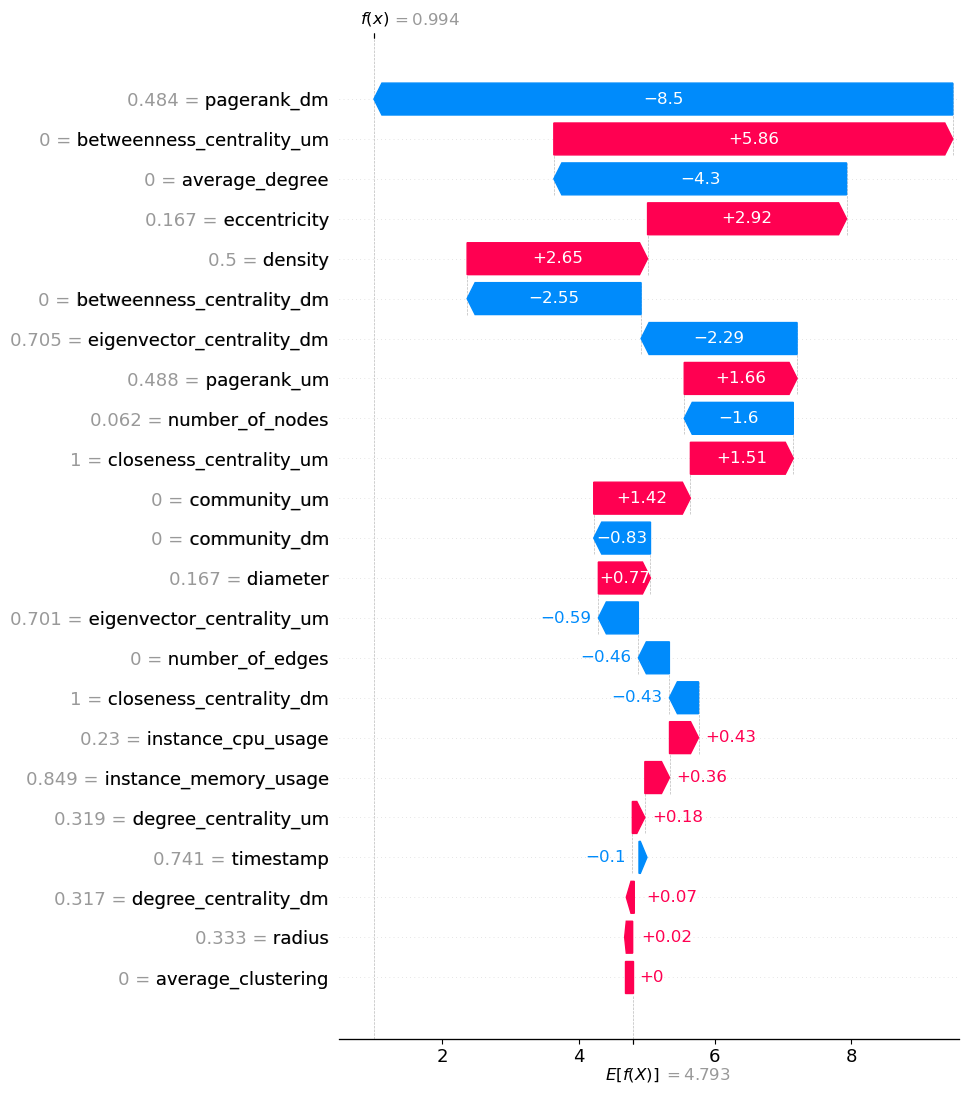

<Figure size 640x480 with 0 Axes>

In [11]:
shap.plots.waterfall(shap_values[0], show=True, max_display=30)
plt.savefig('waterfall_lstm_complex.png', dpi=300, bbox_inches='tight')
plt.show()

<a name='3-4'></a>
### 3.4 - Gráficas Locales

SHAP ofrece la posibilidad de analizar el peso e importancia de las entradas de una observación específica.

Para este modelo, se explorarán dos gráficas para esto:
- Waterfall
- ForcePlot

Ambas gráficas están centradas en un *valor base*, el cual formalmente es el valor esperado del modelo. Sin embargo, este *valor base* se puede calcular como el promedio aritmético de los valores de las predicciones que el *Explainer* recibe.

Dependiendo el tipo de modelo que se use, existen otras gráficas que se pueden usar. Por ejemplo, en aquellos modelos en los que se analiza una imágen como entrada, existe una gráfica que muestra detalles específicos de la imágen que hacen que afecte la predicción del modelo.

#### Waterfall

Para generar la gráfica de tipo **Waterfall** se requiere llamar a la función `shap.plots.waterfall` pasando los valores de SHAP de la observación. Para este ejemplo usaremos los valores de SHAP almacenados en el índice 0.

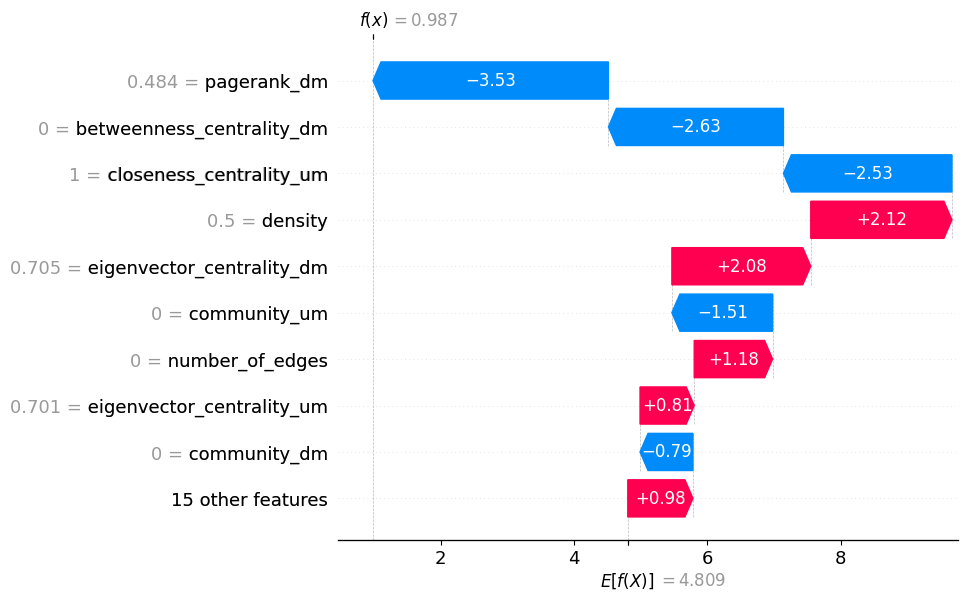

<Figure size 640x480 with 0 Axes>

In [12]:
shap.plots.waterfall(shap_values[0], show=True)
plt.savefig('waterfall_1.png')
plt.show()

In [18]:
# 1. Crear la carpeta 'waterfall' si no existe
output_dir = "waterfall"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 2. Iniciar el loop de 0 a 999
for i in range(1000):
    # Obtener el valor de la predicción (base_value + suma de SHAP values)
    # Generalmente esto se encuentra en shap_values.values[i].sum() + shap_values.base_values[i]
    prediction_value = shap_values[i].values.sum() + shap_values[i].base_values
    
    # 3. Determinar el prefijo según el valor
    if prediction_value > 0:
        prefix = "pos"
    elif prediction_value < 0:
        prefix = "neg"
    else:
        prefix = "zero"
    
    # 4. Configurar y crear el gráfico
    # Nota: shap.plots.waterfall crea su propia figura, por lo que figsize 
    # a veces debe ajustarse dentro del plot o mediante plt.gcf()
    plt.figure(figsize=(20, 15)) # Ajustado a un tamaño más manejable pero grande
    
    # Generar el plot (show=False es clave para poder guardar antes de cerrar)
    shap.plots.waterfall(shap_values[i], max_display=30, show=False)
    
    # 5. Definir el nombre del archivo y la ruta
    filename = f"{prefix}_{i}.png"
    filepath = os.path.join(output_dir, filename)
    
    # 6. Guardar y cerrar
    plt.savefig(filepath, dpi=150, bbox_inches='tight')
    plt.close() # Es vital cerrar la figura en cada loop para no agotar la RAM

print(f"Proceso finalizado. Se han guardado las imágenes en la carpeta '{output_dir}'.")

#### ForcePlot

Esta gráfica requiere JavaScript para funcionar, por lo tanto se inicializa mediante la función `shap.initjs()`.

Para generar la gráfica, se llama a la función `shap.plots.force` pasando los valores de SHAP de la observación. Igual que en la gráfica de tipo Waterfall, usaremos los valores de SHAP almacenados en el índice 0.

In [12]:
shap.initjs()
shap.plots.force(shap_values[0])

Como se puede observar, ambas gráficas muestran la misma información de una manera distinta. Sin embargo, podemos ver las variables que hacen que la predicción del modelo aumente representadas con el color rosado-rojo y las variables que hacen que la predicción del modelo disminuya representadas con el color azul. También se puede apreciar el peso de cada variable en la predicción final del modelo.

<a name='3-5'></a>
### 3.5 - Gráficas Globales

SHAP también ofrece la posibilidad de analizar el peso e importancia de las variables de entrada en el modelo de forma general.

Existen múltiples gráficas disponibles dependiendo del modelo. Para este modelo particular, se explorarán las siguientes gráficas:

- Bar
- Beeswarm

#### Bar

Para generar la gráfica de tipo **Bar** se requiere llamar a la función `shap.plots.bar` pasando todos los valores de SHAP disponibles.

In [13]:
plt.close()

plt.figure(figsize=(10, 8))
shap.plots.bar(shap_values, show=False, max_display=30)
plt.title(f"Importancia de los parámetros - LSTM (Enriquecido)")
plt.tight_layout()
plt.savefig("feature_importance_whole_lstm.png",
    dpi=300, bbox_inches='tight'
)
plt.close()

Esta gráfica muestra un promedio de la contribución de cada componete (el promedio de su valor de SHAP). En general, si el valor es positivo y la barra es de color rosado-rojo, esto indica que este componente hace que la predicción aumente. En caso contrario, si el valor es negativo y la barra es de color azul, el componente hace que la predicción disminuya.

In [29]:
display_question('bar_class_0')

RadioButtons(description='¿Qué feature contribuye más en las predicciones de este modelo?', layout=Layout(widt…

Button(description='Verificar Respuesta', style=ButtonStyle())

Output()

#### Beeswarm

Para generar la gráfica de tipo **Beeswarm** se requiere llamar a la función `shap.plots.beeswarm` pasando todos los valores de SHAP disponibles.

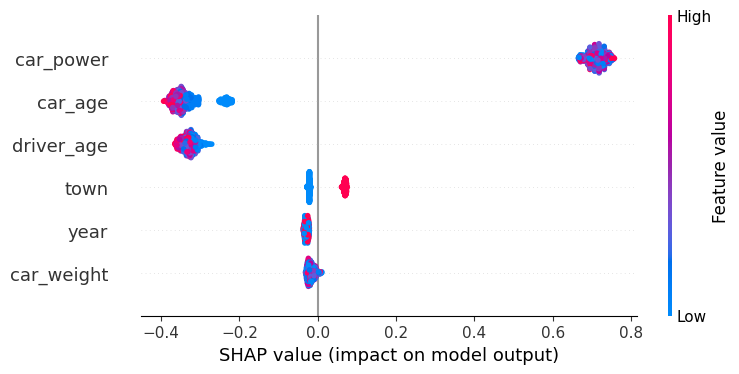

In [30]:
shap.plots.beeswarm(shap_values, show=False)
plt.savefig('generated_images/beeswarm_1.png')
plt.show()

In [31]:
tests.test_beeswarm_plot_classification()

Beeswarm plot test passed! ✅


Esta gráfica brinda bastante información pues nos muestra la distribución de las contribuciones (eje X) de cada componente (eje Y) de acuerdo a su valor real (color de cada punto). Cada punto correspode a una observación particular para el que se le calcularon sus valores de SHAP.

In [32]:
display_question('beeswarm_class_0')

RadioButtons(description='¿Qué feature tiene una distribución clara en contribuciones positivas y negativas de…

Button(description='Verificar Respuesta', style=ButtonStyle())

Output()

In [33]:
display_question('beeswarm_class_1')

RadioButtons(description='Verdadero o Falso: El feature year tiene una contribución que depende de su valor.',…

Button(description='Verificar Respuesta', style=ButtonStyle())

Output()

<a name='4'></a>
## 4 - Modelo de regresión

El dataset para esta sección relaciona algunos datos médicos de personas y el costo de su seguro médico.


In [34]:
df = pd.read_csv("insurance.csv")
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [36]:
# Almacenamos los nombres de las columnas en las variables x y y
y, x = df.columns[-1], list(df.columns[:-1])

<a name='4-1'></a>
### 4.1 - Exploración del Dataset y Pre-Procesamiento

La siguiente celda da un resumen de los datos del dataframe.

In [37]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


El primer paso del preprocesamiento es dividir los datos en train y test. Para esto usaremos la función`train_test_split` incluida en la librería `sklearn`. Haremos una división 90% train, 10% test.

In [38]:
train, test = train_test_split(df, test_size=0.1, random_state=30)

In [39]:
x_train = train.drop('charges', axis=1)
y_train = train['charges']
x_test = test.drop('charges', axis=1)
y_test = test['charges']

Como este dataset tiene columnas con datos categóricos, hay que codificar esta información en algún formato numérico, para lo cual se usará One-Hot Encoding. En este caso, vamos a usar la función de `Pandas`, `pd.get_dummies` la cual aplica One-Hot Encoding a las variables especificadas. Esta función lo que hace es para cada variable, si esta es binaria, el nuevo nombre es la variable original seguido por la primera categoría; si la variable no es binaria, se hace una nueva columna por cada categoría. La siguiente celda aplica One-Hot Encoding tanto al train set como al test set.

In [40]:
x_train = pd.get_dummies(x_train, columns=['sex', 'smoker', 'region'], drop_first=True, dtype=float)
x_test = pd.get_dummies(x_test, columns=['sex', 'smoker', 'region'], drop_first=True, dtype=float)

# Ensure columns are aligned between train and test sets after one-hot encoding
train_cols = list(x_train.columns)
test_cols = list(x_test.columns)

for col in train_cols:
    if col not in test_cols:
        x_test[col] = 0
for col in test_cols:
    if col not in train_cols:
        x_train[col] = 0

x_test = x_test[train_cols] # Reorder test columns to match train columns

El siguiente paso es aplicar una normalización para asegurarnos que los datos estén dentro del intervalo $(-1, 1)$. Esto ayuda con la estabilidad numérica y a mantener los pesos del modelo dentro de rangos numéricamente estables.

La siguiente celda aplica la normalización que definimos anteriormente.

In [41]:
X_train = normalize(x_train)

<a name='4-2'></a>
### 4.2 - Construcción y entrenamiento del modelo

La arquitectura de este modelo es la siguente:

- Primera capa oculta con 32 neuronas y función de activación `Relu`
- Segunda capa oculta con 64 neuronas y función de activación `Relu
- Capa de salida con función de activación lineal.

- Se utiliza el optimizador `Adam`
- Se utiliza la función de pérdida de mínimos cuadrados `mse`
- Se utiliza la función de error absoluto medio `mae` como métrica.

In [42]:
# Define the input layer
input_layer = Input(shape=(x_train.shape[1],)) # Adjust input shape to match the data's features

# Add hidden layers
hidden_layer_1 = Dense(64, activation='relu')(input_layer) # Example number of neurons
hidden_layer_2 = Dense(32, activation='relu')(hidden_layer_1) # Example additional layer

# Add the output layer
output_layer = Dense(1, activation='linear')(hidden_layer_2) # Output layer for regression, linear activation

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', # Specify optimizer
              loss='mse', # Change loss function to Mean Squared Error for regression
              metrics=['mae']) # Change metric to Mean Absolute Error for regression

# Print the model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,689 (10.50 KB)

 Trainable params: 2,689 (10.50 KB)

 Non-trainable params: 0 (0.00 B)

Ahora se entrena el modelo.

Sin embargo, para asegurarnos que la autocalificabilidad funcione correctamente, se va a cargar un modelo pre-entrenado. En caso de querer entrenar el modelo, basta con comentar la segunda linea y des-comentar la primera linea de la siguiente celda.

In [43]:
# model.fit(x_train, y_train, epochs=5)
model = keras.saving.load_model("model2.keras")

<a name='4-3'></a>
### 4.3 - SHAP y Explainers

Como este modelo es de regresión, no es necesario aplicar escala logarítmica a las predicciones del modelo. Sin embargo, igual se deben normalizar los datos de prueba antes de ser enviados al modelo para la inferencia.

La siguiente celda aplica la normalización.

In [44]:
def nn_predict(X):
  df_scaled = normalize(X)
  pred = model.predict(df_scaled, verbose=0, batch_size=10_000).flatten()
  return pred

En la siguiente celda, se usa la clase Explainer, la cual recibe la función nn_predictcomo model.

In [45]:
explainer = shap.Explainer(model=nn_predict, masker=X_train)

Usando `__class__` podemos ver el `Explainer` que SHAP eligió para el modelo

In [46]:
explainer.__class__

shap.explainers._exact.ExactExplainer

Podemos evidenciar que para este modelo también se eligió el `ExactExplainer`.

Otros explainers que SHAP puede elegir (que también se pueden usar manualmente) son:
- DeepExplainer: Optimizado para modelos de aprendizaje profundo. Es una versión mejorada de DeepLIFT (DeepSHAP) en donde los valores de SHAP son aproximados usando una selección de datos de muestra.
- KernelExplainer: Este explainer puede ser usado para explicar cualquier función. Aproxima los valores de SHAP mediante una regresión lineal especial.
- PermutationExplainer: Este explainer, el cual es model agnostic (es decir que funciona para cualquier mdoelo), aproxima los valores de SHAP mediante la iteración de múltiples permutaciones de los datos de entrada.
- TreeExplainer: Este explainer está diseñado para los modelos basados en árboles. Este explainer usa múltiples suposiciones en cuanto a dependencia de features.


Más información de los explainers se puede encontrar en la [documentación oficial de la librería](https://shap.readthedocs.io/en/latest/api.html#explainers).

In [47]:
display_question('explainer_choice')

RadioButtons(description='¿Qué explainer es más eficiente para modelos con menos de 15 features?', layout=Layo…

Button(description='Verificar Respuesta', style=ButtonStyle())

Output()

Finalmente, se deben calcular los valores SHAP para una o múltiples observaciones. Para ello se usa el explainer quièn recibe los datos de entrada del modelo y se devuelven los valores de SHAP para cada observación.

Aunque este proceso es bastante demandante computacionalmente, el test set de este modelo es bastante pequeño, por lo que podemos calcular los valores de SHAP para todas las observaciones del test set.

In [48]:
shap_values = explainer(x_test)

ExactExplainer explainer: 135it [00:28,  3.57it/s]


<a name='4-4'></a>
###4.4 - Gráficas Locales

Para este modelo, se explorarán dos gráficas locales:

- Waterfall
- ForcePlot

#### Waterfall

Para esta gráfica se debe pasar los valores de SHAP para una sóla observación. En este caso, se usarán los valores de SHAP almacenados en el índice $0$.

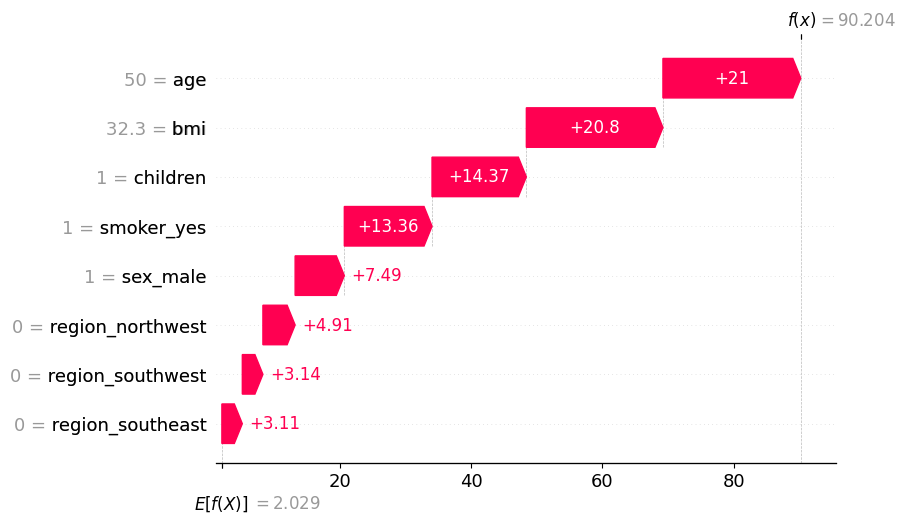

In [49]:
shap.plots.waterfall(shap_values[0], show=False)
plt.savefig('generated_images/waterfall_2.png')
plt.show()

In [50]:
tests.test_waterfall_plot_regression()

Waterfall plot test passed! ✅


####ForcePlot

Esta gráfica requiere cargar JavaScript en la celda.

Para esta gráfica se usarán los mismos valores de SHAP que la gráfica anterior.

In [51]:
shap.initjs()
shap.plots.force(shap_values[0])

In [52]:
display_question('wat_reg_0')

RadioButtons(description='Verdadero o Falso: Para la muestra 0, todos los features tienen contribución positiv…

Button(description='Verificar Respuesta', style=ButtonStyle())

Output()

In [53]:
display_question('wat_reg_1')

RadioButtons(description='Para la muestra 0, ¿qué feature tiene la mayor contribución?', layout=Layout(width='…

Button(description='Verificar Respuesta', style=ButtonStyle())

Output()

<a name='4-5'></a>
###4.5 - Gráficas Globales

Para este modelo, se explorarán las siguientes gráficas globales:

- Bar
- Beeswarm

#### Bar

La gráfica de tipo **Bar** requiere todos los valores de SHAP disponibles.

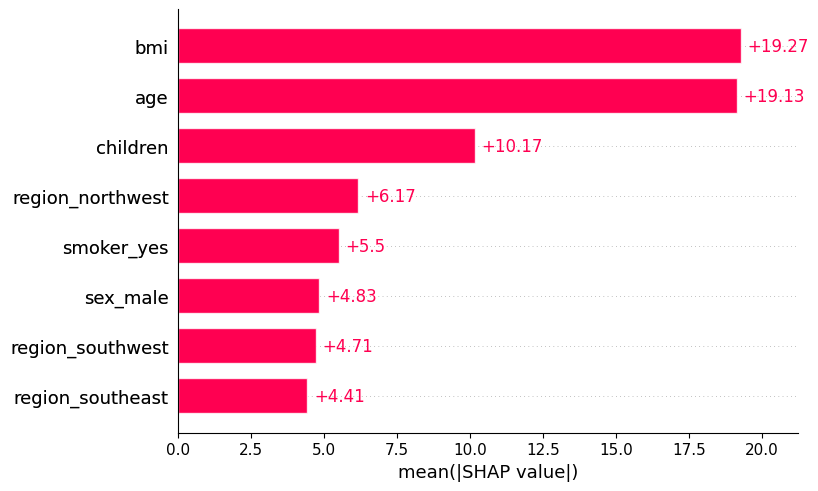

In [54]:
shap.plots.bar(shap_values, show=False)
plt.savefig('generated_images/bar_2.png')
plt.show()

In [55]:
tests.test_bar_plot_regression()

Bar plot test passed! ✅


In [56]:
display_question('bar_reg_0')

RadioButtons(description='Los dos features que más contribuyen a las predicciones de este modelo son:', layout…

Button(description='Verificar Respuesta', style=ButtonStyle())

Output()

In [57]:
display_question('bar_reg_1')

RadioButtons(description='Verdadero o Falso: Para este modelo, en general, todos los features tienen contribuc…

Button(description='Verificar Respuesta', style=ButtonStyle())

Output()

#### Beeswarm

La gráfica de tipo **Beeswarm** requiere todos los valores de SHAP disponibles.

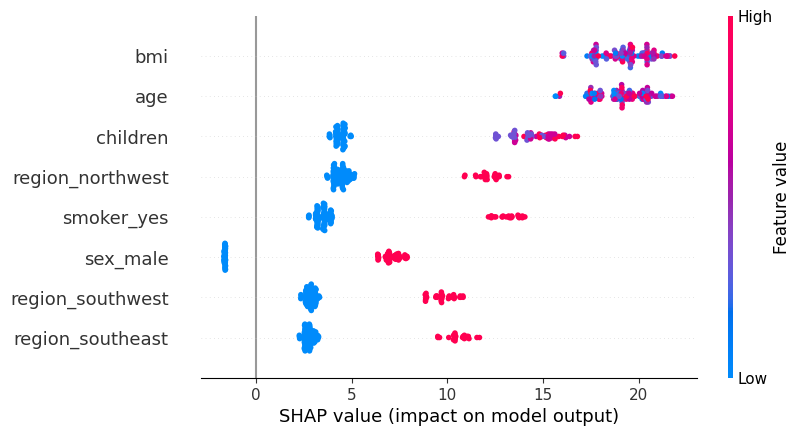

In [60]:
shap.plots.beeswarm(shap_values, show=False)
plt.savefig('generated_images/beeswarm_2.png')
plt.show()

In [61]:
tests.test_beeswarm_plot_regression()

Beeswarm plot test passed! ✅


In [62]:
display_question('beeswarm_reg_0')

RadioButtons(description='Verdadero o Falso: De acuerdo con el modelo, para una persona sin hijos, el seguro m…

Button(description='Verificar Respuesta', style=ButtonStyle())

Output()

In [63]:
display_question('beeswarm_reg_1')

RadioButtons(description='Verdadero o Falso: De acuerdo con el modelo, las mujeres pagan potencialmente más po…

Button(description='Verificar Respuesta', style=ButtonStyle())

Output()

<a name='5'></a>
##5 - Hazlo Tu Mismo (Ungraded)

Para los siguientes datasets, sigue el mismo flujo que se ha trabajado en el notebook para poder hacer interpretabilidad del modelo que se entrenará.

El siguiente dataset reúne transacciones con tarjetas de crédito que se realizaron en Europa en un fragmento de tiempo durante Septiembre de 2013. Casi toda la información está codificada, con excepción del valor de la compra, y el momento de la transacción. El objetivo es predecir si la transacción es fraudulenta.

In [64]:
df = pd.read_csv("creditcard_31ft.csv")
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [ ]:
## ESCRIBE TU CÓDIGO AQUI



El siguiente dataset reúne datos de vehiculos y sus propietarios en Estados Unidos. El objetivo es predecir si la persona hizo un reclamo a su seguro.

In [ ]:
df = pd.read_csv("Car_Insurance_Claim.csv")
df

,ID,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
0,569520,65+,female,majority,0-9y,high school,upper class,0.629027,1.0,after 2015,0.0,1.0,10238,12000.0,sedan,0,0,0,0.0
1,750365,16-25,male,majority,0-9y,none,poverty,0.357757,0.0,before 2015,0.0,0.0,10238,16000.0,sedan,0,0,0,1.0
2,199901,16-25,female,majority,0-9y,high school,working class,0.493146,1.0,before 2015,0.0,0.0,10238,11000.0,sedan,0,0,0,0.0
3,478866,16-25,male,majority,0-9y,university,working class,0.206013,1.0,before 2015,0.0,1.0,32765,11000.0,sedan,0,0,0,0.0
4,731664,26-39,male,majority,10-19y,none,working class,0.388366,1.0,before 2015,0.0,0.0,32765,12000.0,sedan,2,0,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,323164,26-39,female,majority,10-19y,university,upper class,0.582787,1.0,before 2015,0.0,0.0,10238,16000.0,sedan,0,0,1,0.0
9996,910346,26-39,female,majority,10-19y,none,middle class,0.522231,1.0,after 2015,0.0,1.0,32765,NaN,sedan,1,0,0,0.0
9997,468409,26-39,male,majority,0-9y,high school,middle class,0.470940,1.0,before 2015,0.0,1.0,10238,14000.0,sedan,0,0,0,0.0
9998,903459,26-39,female,majority,10-19y,high school,poverty,0.364185,0.0,before 2015,0.0,1.0,10238,13000.0,sedan,2,0,1,1.0


In [ ]:
## ESCRIBE TU CÓDIGO AQUI



<a name='6'></a>
##6 - Bibliografía
- Actuarial-data-science/Tutorials: Code for the Actuarial Data Science Tutorials published at https://actuarialdatascience.org. https://github.com/actuarial-data-science/Tutorials/blob/master/14%20-%20SHAP/shap_tutorial.ipynb
- Shap/Shap: A game theoretic approach to explain the output of any machine learning
model. https://github.com/shap/shap?tab=readme-ov-file
- Lundberg, Scott M. ; Lee, Su-In: A Unified Approach to Interpreting Model Predic-
tions. Curran Associates, Inc., 2017
- Mayer, Michael ; Meier, Daniel ; Wuthrich, Mario: SHAP for Actuaries: Explain
any Model. En: SSRN Electronic Journal (2023), 03, p. 25
- Nasteski, Vladimir: An overview of the supervised machine learning methods. En:
HORIZONS.B 4 (2017), 12, p. 51–62
- Ng, Andrew ; Ma, Tengyu. CS229 Lecture Notes. 2023
- Norvig, Stuart J. Russell P.: Artificial Intelligence. A Modern Approach. Pearson,
Upper Saddle River, 2020. – ISBN 978–0134610993
- Yadav, Amit. SHAP Values Explained. https://medium.com/biased-algorithms/shap-values-explained-08764ab16466
- Oliveira, Willian. Healthcare Insurance https://www.kaggle.com/datasets/willianoliveiragibin/healthcare-insurance?resource=download
- Roy, Sagnik. Car Insurance Data https://www.kaggle.com/datasets/sagnik1511/car-insurance-data/data
- ULB, Machine Learning G. Credit Card Fraud Detection https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data